### Multi-Layer Perceptron MNIST with Validation

In [1]:
# 1. Load and Visualize data
# 2. Define a neural network
# 3. Train the model
# 4. Evaluate the performance on test dataset

In [2]:
import torch
import numpy as np

#### Load and Visualize data

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)

test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

# obtrain training indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

#### Visualize a Batch if Training Data

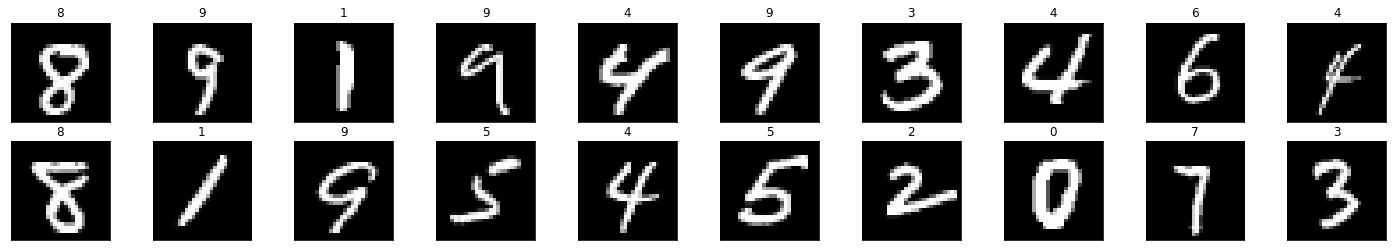

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in batch, along with corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

#### Define the Network Architecture


In [5]:
from torch import nn, optim
import torch.nn.functional as F

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [7]:
# define loss
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


#### Train the Network

In [8]:
# 1. Clear the gradients
# 2. Forwards pass
# 3. Calculate loss
# 4. Backward pass
# 5. optimization step
# 6. Update average training loss

In [10]:
epochs = 20

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    
    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
    
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss, 
        valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}), saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
    
    

Epoch: 1 	Training Loss: 0.284437 	Validation Loss: 0.059595
Validation loss decreased (inf --> 0.059595), saving model ...
Epoch: 2 	Training Loss: 0.226962 	Validation Loss: 0.048655
Validation loss decreased (0.059595 --> 0.048655), saving model ...
Epoch: 3 	Training Loss: 0.186444 	Validation Loss: 0.041765
Validation loss decreased (0.048655 --> 0.041765), saving model ...
Epoch: 4 	Training Loss: 0.158884 	Validation Loss: 0.037206
Validation loss decreased (0.041765 --> 0.037206), saving model ...
Epoch: 5 	Training Loss: 0.137609 	Validation Loss: 0.032738
Validation loss decreased (0.037206 --> 0.032738), saving model ...
Epoch: 6 	Training Loss: 0.123785 	Validation Loss: 0.030007
Validation loss decreased (0.032738 --> 0.030007), saving model ...
Epoch: 7 	Training Loss: 0.109513 	Validation Loss: 0.028166
Validation loss decreased (0.030007 --> 0.028166), saving model ...
Epoch: 8 	Training Loss: 0.099745 	Validation Loss: 0.025637
Validation loss decreased (0.028166 --> 0

In [20]:
model.load_state_dict(torch.load('model.pt'))

#### Test the Trained Network

In [22]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for images, labels in test_loader:
    # forward pass
    output = model(images)
    # calculate loss
    loss = criterion(output, labels)
    # update test loss
    test_loss += loss.item()*images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.071090

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 97% (955/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 97% (9778/10000)
